<a href="https://colab.research.google.com/github/qwertyqwertyqwertyqwerty123/colab_projects/blob/main/lin_log_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# DIR PATH to DATA
dir_path = "/content/drive/My Drive/"
csv_file_path = dir_path + "insurance.csv"
csv_file_path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/My Drive/insurance.csv'

In [ ]:
data = pd.read_csv(csv_file_path)
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          1338 non-null   int64  
 1   sex          1338 non-null   object 
 2   bmi          1338 non-null   float64
 3   children     1338 non-null   int64  
 4   smoker       1338 non-null   object 
 5   region       1338 non-null   object 
 6   charges      1338 non-null   float64
 7   log_charges  1338 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 83.8+ KB


In [ ]:
# смотрим количество пропусков для каждого признака
data.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0
log_charges,0


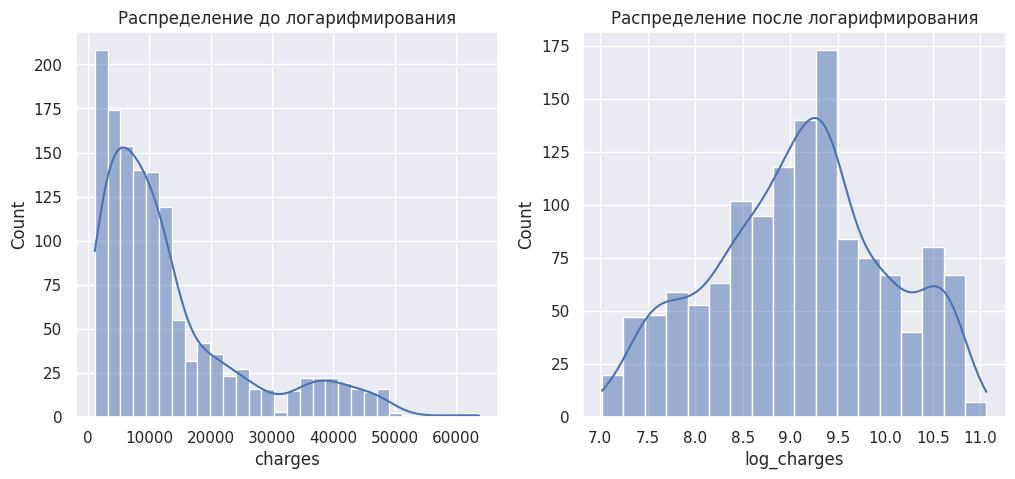

In [ ]:
# логарифмированние целевой переменной +график
data['log_charges'] = np.log(data['charges'])
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data['charges'], kde=True)
plt.title('Распределение до логарифмирования')
plt.subplot(1, 2, 2)
sns.histplot(data['log_charges'], kde=True)
plt.title('Распределение после логарифмирования')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X = data.drop(['charges', 'log_charges'], axis=1)
y = data['log_charges']

# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

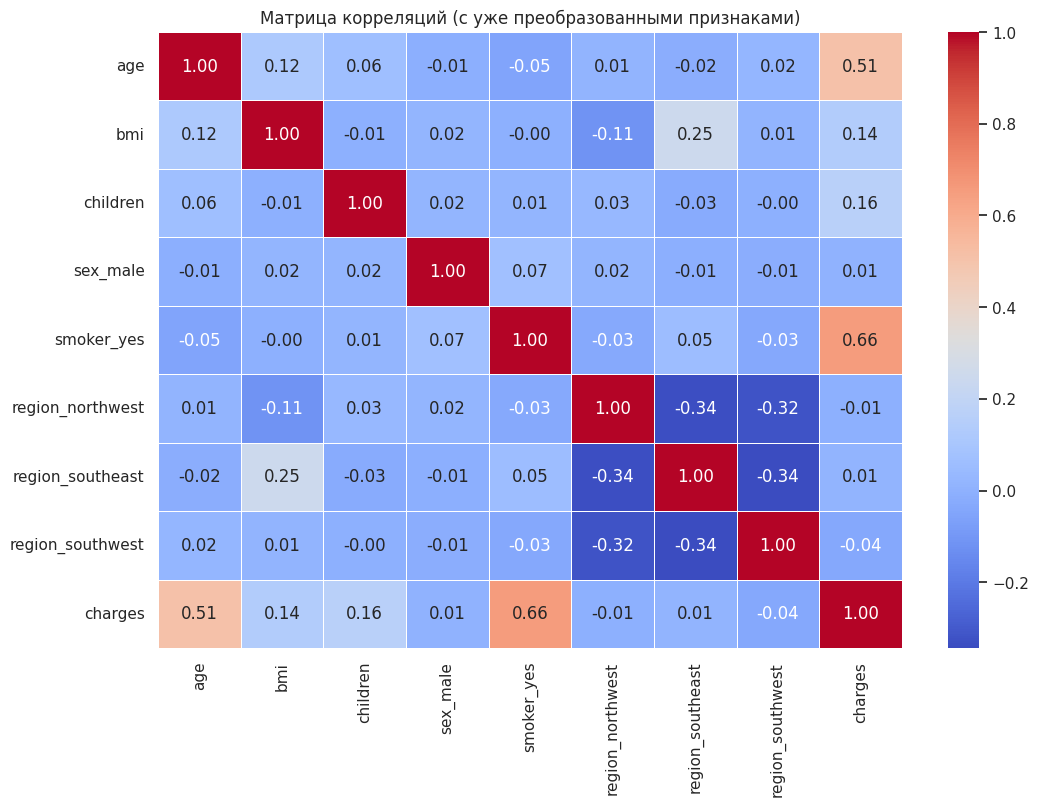

In [ ]:
# преобразование нечисловых переменных (с использованием one hot encoder)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numerical_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# получение имен для столбцов
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
train_processed_data = pd.DataFrame(X_train_processed, columns=feature_names)
train_processed_data['charges'] = y_train.reset_index(drop=True)

# Построение табл межфакторных корреляций
plt.figure(figsize=(12, 8))
corr_matrix = train_processed_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Матрица корреляций (с уже преобразованными признаками)")
plt.show()

В таблице видно, что между факторными признаками нет какой-либо значимой корреляции.
Стоит отметить, что на стоимость страховки сильно факт наличия у клиента привычки к курению.

In [ ]:
# строим линейную регрессию
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

model = LinearRegression()
model.fit(X_train_processed, y_train)

LinearRegression()

In [ ]:

y_pred = model.predict(X_test_processed)
print(f"\nMSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")
print (f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")


MSE: 0.18
R²: 0.80
MAE: 0.27


По полученному значению коэффициента детерминации, можно сказать, что с помощью построенной модели можно объяснить 78% вариации результативного признака (цены страховой премиии)

In [ ]:
# построение логистической регрессии
from sklearn.linear_model import LinearRegression, LogisticRegression

# разделение y по медиане
y_binary = (y > y.median()).astype(int)

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X, y_binary, test_size=0.2, random_state=42)
X_train_log_processed = preprocessor.fit_transform(X_train_log)
X_test_log_processed = preprocessor.transform(X_test_log)

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_log_processed, y_train_log)

LogisticRegression(max_iter=1000)

In [ ]:
# Предсказание и оценка
y_pred_log = logistic_model.predict(X_test_log_processed)
y_pred_proba = logistic_model.predict_proba(X_test_log_processed)[:, 1]  # Вероятности класса 1

from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score)
print("Оценка логистической регрессии:")
print(f"Accuracy: {accuracy_score(y_test_log, y_pred_log):.2f}")
print(f"F1-score: {f1_score(y_test_log, y_pred_log):.2f}")
print(f"Precision: {precision_score(y_test_log, y_pred_log):.2f}")
print(f"Recall: {recall_score(y_test_log, y_pred_log):.2f}")

Оценка логистической регрессии:
Accuracy: 0.91
F1-score: 0.90
Precision: 0.88
Recall: 0.93


ВЫВОД:
Обе модели достаточно точно справляются с поставленной задачей.
1) В случае с *линейной регрессией* , с вероятностью в 95% можно сказать, что она объясняет 80% дисперсии результативного признака (то есть достаточноо хорошо предсказывает стоимость страховки).
2) В случае с *логистической регрессией* , при разделении Y по медиане модель классифицирует правильно в 91% случаев.
В обеих моделях наибольшее влияение на стоимость страховки оказывает факт курения и возраст клиента.
